In this project, I build a LSTM-based sentiment classification model to classify custormer's behaviour buying clothes and jewerly in the Amazon website based on their reviews of ordered products leaving on the website. The model's output is a 3-class output which are postivie, negative and neutral.
This project uses a pretrained word2vec model to embed sentences into word embedding vectors. Then the LSTM model will use these embedding vectors to train the model.

Firstly, I load the dataset and drop missing values in the dataset. Initially , the complete dataset was nearly about 14 GBs. Because of the limitation of hardware and time, I created smaller chuck sizes of that dataset, and created a separate dataset out of it with summary,overall,reviewText columns to enhance the training process. In the future, maybe I can train the model with all of the data 

In [372]:
import pandas as pd
data=pd.read_csv('balanced_review/clothe_jewerly_review.csv', sep=',', header = 0)
data_sub = data.loc[:].sample(100000, random_state=1)
data_sub.head()
#drop the missing value
data1 = data_sub.copy()
data1.dropna(inplace = True)
data1.isnull().sum()

overall       0
reviewText    0
summary       0
dtype: int64

In [373]:
data1.head()

overall                                         reviewText  \
537411        3  Shipped quickly! Looks very unique and works g...   
90905         2  Cute, but tight on the outside of my feet. I d...   
483959        5                                          Very good   
294414        4                                Very nice bracelet!   
288292        5  Amazing build quality and enough room for my D...   

                      summary  
537411                   Nice  
90905   made for narrow feet.  
483959             Five Stars  
294414             Four Stars  
288292                 Wow!!!

In this dataset, the "overall" column indicates the rating (from 1 to 5) which custormers vote for the ordered products  

In [374]:
data1['overall'].value_counts()

3    33649
5    16633
2    16598
4    16566
1    16449
Name: overall, dtype: int64

In this projec, my classification model is a 3-class output model. Thus, I will assign new labels based on the rating points. 
The rating point which 1 or 2 is negative review. I assign them as 0
The rating point which 4 or 5 is positive review. I assign them as 1
The rating point which 3 is neutral review. I assign them as 2

In [375]:
def assignNewLabels(label):
    if label == 1 or label == 2:
        return 0
    elif label == 4 or label == 5:
        return 1
    elif label == 3:
        return 2
data1['overall'] = data1['overall'].apply(assignNewLabels)
data1['overall'].value_counts()

2    33649
1    33199
0    33047
Name: overall, dtype: int64

# Then, we need to clean data by doing som preprocess step:
1. Tokenizing sentences to break text down into sentences, words, or other units
2. Removing stop words like “if,” “but,” “or,” and so on
3. Normalizing words or emmatizing by condensing all forms of a word into a single form

In [376]:
data1.head()

overall                                         reviewText  \
537411        2  Shipped quickly! Looks very unique and works g...   
90905         0  Cute, but tight on the outside of my feet. I d...   
483959        1                                          Very good   
294414        1                                Very nice bracelet!   
288292        1  Amazing build quality and enough room for my D...   

                      summary  
537411                   Nice  
90905   made for narrow feet.  
483959             Five Stars  
294414             Four Stars  
288292                 Wow!!!

In [377]:
data2=pd.DataFrame(data1,columns=['reviewText','overall'])
data2

reviewText  overall
537411  Shipped quickly! Looks very unique and works g...        2
90905   Cute, but tight on the outside of my feet. I d...        0
483959                                          Very good        1
294414                                Very nice bracelet!        1
288292  Amazing build quality and enough room for my D...        1
...                                                   ...      ...
675265  We purchase crocs every year at the beginning ...        1
284653  These are junk do not buy, after only 4 months...        0
599465  I ordered these tags. One was clearly used -- ...        0
584376  The leather is not very soft and I am still ge...        2
496295                To small for me gave it to my neice        0

[99895 rows x 2 columns]

In [405]:
import nltk
from nltk.corpus import stopwords
import re
import numpy as np
from nltk.stem import WordNetLemmatizer

stop = set(stopwords.words('english'))

def numberEraser(row):
    #this function removes number and special character of each sentence in dataset
    if type(row) not in [int,float]:
        line = re.sub(r"[^A-Za-z\s]", " ", row.strip())
        tokens = line.split()
    else:
        tokens=[]
    print(' '.join(tokens))
    return ' '.join(tokens)

wordnetLemmatizer = WordNetLemmatizer()

def stopWordEraserAndLemmatizer(row):
    #this function remove stop words which is not necessary and do the word lemmatization process for the model to learn hidden features from the dataset
    tokens = nltk.wordpunct_tokenize(row)
    filterTokens = [t for t in tokens if not t.lower() in stop] #choose words not being listed in stop words list
    tokenLemmatized=[]
    #do the word lemmatization process (remove "ing" or "ed") and return the sentence with the simplest form    
    for i in filterTokens:
        tokenLemmatized.append(wordnetLemmatizer.lemmatize(i))
        
    return ' '.join(tokenLemmatized)
            

def dataCleaner(data):
    data['reviewText'] = data['reviewText'].apply(numberEraser)
    data['reviewText'] = data['reviewText'].apply(stopWordEraserAndLemmatizer)
        
        
dataCleaner(data2)
data2.head()

Shipped quickly Looks very unique and works great for carrying a few extra things around for a year old once we retired the diaper bag Would have given this owl pack a star rating if the material quality were better
Cute but tight on the outside of my feet I decided to return them because I was afraid they would split
Very good
Very nice bracelet
Amazing build quality and enough room for my DJ mixer Loads of pockets for all kinds of things Really amazing
They re pretty much useless because they made them with the needlework OVER THE TIP OF THE FINGERS So the part of the glove that should have the most of the silver compounds is just a lot of fluff hanging around I bought these because once I got a pair during a trip to Netherlands the quality of those was superior but sadly I lost them This pair of gloves in particular was just a waste of money
The stainless Steel Rolo Cable Chain is a wonderful chain to hang my lockets or charms on The length is just right and it looks great
Its defin

Poor fit
Love
Didn t fit right and zipper not well made
Received misshapen desperately needs to be reblocked Tied to hopefully reshape pain in the ass to send back Bowler was fine may never wear Homburg
Purchased this bathing suit in black exactly a year ago Have worn it literally times washed it once on very gentle cycle no fabric softner cold water and hang dry It literally has fallen apart in the bust area The stitching started to unravel and eventually caused the actual fabric to rip throughout the day and the rubber pipping to pop out For it should not have a wear times maximum Really adorable suit and fits great but extremely poorly made
It was a little too big
I like this particular style it fits really well However nothing in the description indicated these were distressed jeans with holes in several places Very disappointed so sent them back
This shoe brand runs small I took that into account when I ordered but they were still a little small They are pretty
Was not a tshirt It

These shoes come larger than normal shoes so if you plan on purchasing them buy them a half size smaller than what you would normally wear Otherwise my mom and her siblings got a kick out of me wearing the shoes she used to wear as a kid Very comfortable but again these shoes run big
These shoes are still as great as I remember them being They fit perfect and are very classy You can never go wrong with Vans
So comfortable Very beautiful and the shirt is stable doesn t slip around Stays put around your shoulders Very sexy LOVE IT
I decided to take a chance with this purchase though my luck with purchasing bathing suits on Amazon has not been great However this one fits ok I m not in love with it but its a cute pattern The Top is more of a string bikini style which I m not to fond of You can wear the top two ways but i chose to wear it more of traditional halter because I would feel as if I m choking on my girls I normally wear around and X X but I bought the X The suit runs small the bo

Great anniversary gift I loved them definitely worth it Just if you have arm hair they might get occassionally pulled lol
This bracelet is beautiful Feels solid has a nice clasp and it s round on the inside to feel comfortable on your wrist but squared on the outside to give it a chunkier but classy look Great with jeans or suits and dresses
Totally mis marked Yes the listing AND the label say women s the sock size which is supposed to fit up to a women s size shoe Uh uh I wear an and the foot bed isn t long enough Also knee high does NOT mean the same thing as mid calf high I think perhaps these socks were made according to girls sizes and then mislabeled in the factory I don t know I just know that I recently purchase pairs of knee highs all allegedly size and only THESE socks did not fit me
Poorly constructed The straps don t cross in the back as the show in the photo I don t recommend
I wish the frame was larger Overall I do like them
wow surprised at the poor tight toe fit for the

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Way too small Had to return
Bigger than expected
So ugly cheap looking Returned it
All the reviews were great for this lovely belt It isn t quite adjustable and doesn t hold or create a waistline I would have given more stars however my belt just came without a clasp at all If this was one off experience then I would still recommend this belt
The boots are larger that the other bearpaw
Because it s sick ass and who doesn t love doctor who stuff it s warm and let s me show my love for doctor who
This lapis lazuli stone has been dyed I have blue coming off on my skin It s a nice pendant but I would prefer to not look like an avatar when I wear it Hopefully it stops staining my skin
First of all I noticed that the denim was unusually thin for jeans I always wash new clothes before wearing and for this jeans it turned out to be not such a good thing It shrunk I mean really shrunk after the first wash to the point where I cannot wear it I am not sure if I can get refund for this since I al

too small At least sizes I ordered my regular size and it was too small then I ordered one size larger and they were too small When I compared the sizing they were the same No difference Pants look good but are not sized correctly
too small
Cute but a waste of money I m a size ordered and they re still too small the rubbing is worst in front
Lovely looking shoe but I don t feel safe walking in it The heel feels wobbly as if I may fall if I m not extremely careful about how I walk in them This lowered my confidence about the shoe and ultimately I gave the away It may be the design of the shoe but it was not a comfortable fit
would fit my grandkids
Dissapointed The silver on the bracelet looks tarnished and detracts from the sparkle of the crystals
Design is nice but Too big I ordered a size small and it seems to do So I gave as a gift to a friend Size only seems to be a great sangpumin are correct
Well its a good think i know how to sew This dress is exactly the price Im a small girl wa

Love these but sizing is off due to cut of shoe Might go up a size to see if it fits
Outfit was as cute as could be BUT the one and only reason I got this outfit was for my sons first birthday and the being on the outfit Nope there is no printed on the shirt I would not have paid this much for a onesie had I known it did not come with the
Arrived quickly Fit as expected Great quality Very soft Would recommend
div id video block R FQVLEQ Z TT class a section a spacing small a spacing top mini video block div input type hidden name value https images na ssl images amazon com images I A X n cp S mp class video url input type hidden name value https images na ssl images amazon com images I JOD fV S png class video slate img url nbsp I bought the shoes in March and have worn them four times and are falling apart
This dress is super cute however it is not that well made so unfortunately I do not think it will make it through another wash or two The fabric is acceptable but the sewing around 

perfect
Man these are so nice but at a pop I wish they were cheaper They do a great job of keeping my nether regions cool in hot weather
So cute Love it
Very cute on Exactly how I wanted it to fit Very light weight Haven t wore for the day as of yet or washed I m sure it will be fine in the gentle cycle with hang to dry It ll last throughout the summer which is what it s for Super fast delivery
I personally don t care about the under the seat angle I d rather have my backpack there with a laptop tablet etc What is really GREAT is this bag FITS IN ALL THE SMALL OVERHEAD BINS YES Many newer planes like the and have limited overhead storage Even a isn t allowed and gets gate checked Also many gate agents have been forcing gate checks on larger planes even when there is lots of room left I got tired of the drama my time is too valuable THIS bag was perfectly designed to ALWAYS fit in the smallest overhead bins for the and commuter jets Now I get to just breeze on and off every flight and t

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



reviewText  overall
537411  Shipped quickly Looks unique work great carryi...        2
90905   Cute tight outside foot decided return afraid ...        0
483959                                               good        1
294414                                      nice bracelet        1
288292  Amazing build quality enough room DJ mixer Loa...        1

In [406]:
data2.values[0, 0]

'Shipped quickly Looks unique work great carrying extra thing around year old retired diaper bag Would given owl pack star rating material quality better'

In [407]:
data2.isnull().sum()

reviewText    0
overall       0
dtype: int64

In [408]:
from tensorflow.keras.utils import to_categorical
x=data2.reviewText
y=data2.overall
y = to_categorical(y)
print(x.shape, y.shape)

(99895,) (99895, 3)


# Secondly, we need to encode the sentences in the dataset as interger. 
Note that, these encoding are not the word embedding of the dataset because after this step we will use a pretrained word embedding model to get the word embdedding vector of each sentence in the dataset

In [409]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
vocabSize = len(tokenizer.word_index) + 1
# integer encode the documents
encodedDocs = tokenizer.texts_to_sequences(x)
# pad documents to a max length of 48 words
maxLength = 48
paddedDocs = pad_sequences(encodedDocs, maxlen=maxLength, padding='post')

Split dataset into train set and test set. Here the training set is 90% of dataset. The test set is 10% of dataset

In [410]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(paddedDocs, y, random_state=4, test_size=0.1)
print(x_train.shape)
print(y_train.shape)

(89905, 48)
(89905, 3)


# Now, we will use a pretrained Word2vec model to get word embedding vector of each sentence in dataset. 
We will load word vectors trained on google news dataset of 3 Billion words. This dictionary consists of 3 million unique word vectors, which is much bigger than GloVe. Each vector is 300 dimensions long.

We will use the gensim library to extract word vectors from the google news vector database.

The function “getVector” is used to get the word vector for a word passed as an argument.

In [378]:
from gensim.models.keyedvectors import KeyedVectors
#load Google Word2Vec model
word2vecModel = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#get embedding vector of word
def getVector(str):
    if str in word2vecModel:
        return word2vecModel[str]
    else:
        return None
#test word2Vec model
vector = getVector("Life")
print(vector)

[-0.25195312  0.13085938  0.05053711 -0.04174805  0.17675781 -0.109375
  0.01074219  0.21972656  0.14941406  0.01855469  0.09619141  0.28515625
 -0.21875    -0.01147461 -0.21582031  0.15429688  0.18945312  0.04638672
 -0.16113281  0.12890625  0.234375    0.13183594 -0.06396484  0.37109375
 -0.08447266  0.10107422 -0.06201172  0.22363281  0.22558594 -0.22460938
  0.06201172  0.06933594 -0.15527344 -0.23730469  0.10449219  0.06933594
  0.06787109 -0.21289062  0.02172852  0.06982422  0.17773438 -0.27929688
 -0.25976562  0.18847656 -0.08154297 -0.11914062  0.02758789  0.16796875
  0.13964844  0.01196289 -0.24804688 -0.03710938  0.15234375  0.11572266
 -0.13867188 -0.07275391 -0.01220703 -0.08740234 -0.20214844 -0.06689453
  0.18164062  0.19042969  0.12792969  0.11425781 -0.04345703  0.18652344
  0.03564453  0.27734375  0.0703125  -0.07519531 -0.06689453 -0.13867188
  0.18554688  0.18652344 -0.08837891 -0.15917969 -0.07470703 -0.14941406
 -0.0559082   0.11132812  0.21386719 -0.26171875  0.3

These procured Embeddings are saved in a matrix variable “embedding_matrix”, whose index will be the dedicated integer of the word during word_index dictionary.

The matrix is used to initialize weights in the Embedding layer of the model.

In [411]:
# create a weight matrix for words in training docs
embeddingMatrix = np.zeros((vocabSize, 300))
for word, i in tokenizer.word_index.items():
    embeddingVector = getVector(word)
    if embeddingVector is not None:
        embeddingMatrix[i] = embeddingVector

# Next, we define the model. In this project, I use the LSTM algorithms which is very common in hadling senquential data problem such as nlp or time series forecasting

In [351]:
from keras.models import Sequential
from keras.layers import LSTM,Dense, Dropout
from keras.layers import Embedding
embedding_vector_length = 300
model = Sequential() 
model.add(Embedding(vocabSize, embedding_vector_length, weights=[embeddingMatrix], trainable=True, input_length=48) )
model.add(LSTM(64, dropout=0.4, activation='relu', return_sequences=True))
model.add(LSTM(32, dropout=0.5, activation='relu'))
model.add(Dense(3, activation='softmax')) 
model.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics=['accuracy'])  
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 48, 300)           10596900  
                                                                 
 lstm_21 (LSTM)              (None, 48, 64)            93440     
                                                                 
 lstm_22 (LSTM)              (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 3)                 99        
                                                                 
Total params: 10,702,855
Trainable params: 10,702,855
Non-trainable params: 0
_________________________________________________________________
None


# Next, we fit the training data to the model and use 20% of that for validation

In [379]:
from keras.models import load_model
model=load_model('model_LSTM.h5')
history = model.fit(x_train,y_train,validation_split=0.2, epochs=10, batch_size=100)

Epoch 1/10
720/720 [==============================] - 45s 60ms/step - loss: 0.5697 - accuracy: 0.7602 - val_loss: 0.6999 - val_accuracy: 0.6947
Epoch 2/10
720/720 [==============================] - 44s 61ms/step - loss: 0.6700 - accuracy: 0.7674 - val_loss: 0.7900 - val_accuracy: 0.6824
Epoch 3/10
720/720 [==============================] - 45s 63ms/step - loss: 3.0213 - accuracy: 0.7747 - val_loss: 11.6938 - val_accuracy: 0.6639
Epoch 4/10
720/720 [==============================] - 44s 62ms/step - loss: 13.1259 - accuracy: 0.7830 - val_loss: 0.7268 - val_accuracy: 0.6888
Epoch 5/10
720/720 [==============================] - 45s 62ms/step - loss: 23.2614 - accuracy: 0.7507 - val_loss: 4.4355 - val_accuracy: 0.6806
Epoch 6/10
720/720 [==============================] - 44s 62ms/step - loss: 0.6147 - accuracy: 0.7840 - val_loss: 1.9437 - val_accuracy: 0.6836
Epoch 7/10
720/720 [==============================] - 43s 60ms/step - loss: 0.8114 - accuracy: 0.7954 - val_loss: 0.8490 - val_accura

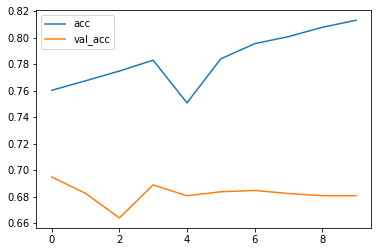

In [380]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

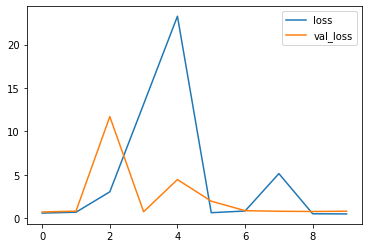

In [381]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Finally, we evaluate the model.

In [386]:
# evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 67.357355


Save the model to use after that. We can continue training the saved model

In [387]:
model.save('model_LSTM.h5')

# Test the saved model with the test set

Text(0.5, 51.0, 'Predicted')

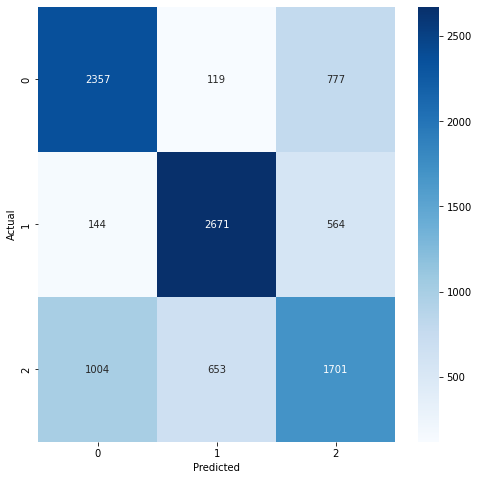

In [388]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
y_pred=np.argmax(model.predict(x_test), axis=-1)
y_pred[1]
y_test=np.argmax(y_test, axis=1)
y_test[1]
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [389]:
from sklearn.metrics import classification_report
print(f'Classification Report: \n {classification_report(y_test,y_pred)}')

Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.72      0.70      3253
           1       0.78      0.79      0.78      3379
           2       0.56      0.51      0.53      3358

    accuracy                           0.67      9990
   macro avg       0.67      0.67      0.67      9990
weighted avg       0.67      0.67      0.67      9990



In [403]:
from keras.models import load_model
def predictSentiment(text):
    #First we need clean the text by removing number and special character and remving stop words
    numberEraser(text)
    stopWordEraserAndLemmatizer(text)
    tw = tokenizer.texts_to_sequences([text])#convert text to interger values
    tw = pad_sequences(tw,maxlen=48, padding='post')
    model=load_model('model_LSTM.h5')#load the trained model
    prediction = np.argmax(model.predict(tw), axis=-1)
    if prediction == 1:
        prediction = "positive"
    elif prediction == 0:
        prediction = "negative"
    elif prediction == 2:
        prediction = "neutral"
    print("Predicted label: ", prediction)

In [414]:
text= "Too beautiful"
predictSentiment(text)

Too beautiful
Predicted label:  neutral


In [394]:
text="very love it!"
predictSentiment(text)

very love it
Predicted label:  positive


In [393]:
text="this cat is quite ok"
predictSentiment(text)

this cat is quite ok
Predicted label:  neutral
